# Определение стоимости автомобилей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [66]:
import pandas as pd
import numpy as np
from math import sqrt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 50), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [4]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346710 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        346710 non-null  object
 1   Price              346710 non-null  int64 
 2   VehicleType        313194 non-null  object
 3   RegistrationYear   346710 non-null  int64 
 4   Gearbox            330292 non-null  object
 5   Power              346710 non-null  int64 
 6   Model              334243 non-null  object
 7   Kilometer          346710 non-null  int64 
 8   RegistrationMonth  346710 non-null  int64 
 9   FuelType           317634 non-null  object
 10  Brand              346710 non-null  object
 11  Repaired           280398 non-null  object
 12  DateCreated        346710 non-null  object
 13  NumberOfPictures   346710 non-null  int64 
 14  PostalCode         346710 non-null  int64 
 15  LastSeen           346710 non-null  object
dtypes: int64(7), object(

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

* Price — цена (евро) — целевой признак

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,346710.000000,346710.000000,346710.000000,346710.000000,346710.000000,346710.0,346710.000000
mean,4473.681656,2003.962776,120.150457,128725.678521,5.778743,0.0,50638.224623
std,4525.807399,70.902869,52.907342,37161.146701,3.698917,0.0,25753.098720
min,0.000000,1000.000000,51.000000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,49497.000000
75%,6499.000000,2008.000000,145.000000,150000.000000,9.000000,0.0,71144.000000
max,20000.000000,9999.000000,1000.000000,150000.000000,12.000000,0.0,99998.000000


### Предобработка данных

Для задачи предсказания цены не обязательно держать в датасете некоторые столбцы:

* NumberOfPictures
* PostalCode
* DateCrawled
* LastSeen

Сразу удалю дубликаты и неинформативные столбцы.

In [7]:
df = df.drop_duplicates().drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346706 entries, 0 to 346705
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             346706 non-null  int64 
 1   VehicleType       313190 non-null  object
 2   RegistrationYear  346706 non-null  int64 
 3   Gearbox           330288 non-null  object
 4   Power             346706 non-null  int64 
 5   Model             334239 non-null  object
 6   Kilometer         346706 non-null  int64 
 7   FuelType          317630 non-null  object
 8   Brand             346706 non-null  object
 9   Repaired          280394 non-null  object
 10  DateCreated       346706 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.1+ MB


#### DateCreated

Удалю строки, в которых дата создания объявления меньше даты регистрации авто.

In [9]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCreated'] = pd.DataFrame(pd.DatetimeIndex(df['DateCreated']).year)
df['DateCreated'] = df['DateCreated'].astype('int64')

In [10]:
df.query('RegistrationYear > DateCreated')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no,2016
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no,2016
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN,2016
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes,2016
57,2399,NaN,2018,manual,64,other,125000,NaN,seat,no,2016
...,...,...,...,...,...,...,...,...,...,...,...
346452,3600,NaN,2017,manual,86,transit,150000,gasoline,ford,NaN,2016
346480,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN,2016
346542,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no,2016
346592,1250,NaN,2018,NaN,61,corsa,150000,petrol,opel,NaN,2016


In [11]:
df = df.query('~(RegistrationYear > DateCreated)')

Теперь удалю столбец DateCreated как неинформативный.

In [12]:
df = df.drop(['DateCreated'], axis=1).reset_index(drop=True)

#### Price

В столбце Price есть некорректные значения — когда цена равна нулю. Т.к. это целевой признак, будет неправильно заполнять это значение чем-то.

In [13]:
print(f'Количество нулевых значений равно {(df["Price"][df["Price"] == 0].count())}.')

Количество нулевых значений равно 8733.


In [14]:
print(f'Это примерно {(df["Price"][df["Price"] == 0].count() / len(df) * 100).round(3)}% от общего количества. Я удалю эти значения.')

Это примерно 2.623% от общего количества. Я удалю эти значения.


In [15]:
df = df.loc[df['Price'] != 0]

In [16]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,101,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
332945,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
332946,1150,bus,2000,manual,125,zafira,150000,petrol,opel,no
332948,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
332949,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### VehicleType

В столбце большой процент пропусков, удалять их опасно. Заменю заглушкой.

In [17]:
print(f'Количество пропусков — {(df["VehicleType"].isna().sum() / len(df) * 100).round(3)}%')
df['VehicleType'].isna().sum()

Количество пропусков — 5.452%


17676

In [18]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

#### RegistrationYear

В этом столбце есть очень странные года!

In [19]:
df['RegistrationYear'].describe()

count    324218.000000
mean       2002.620046
std          10.409568
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

<Axes: >

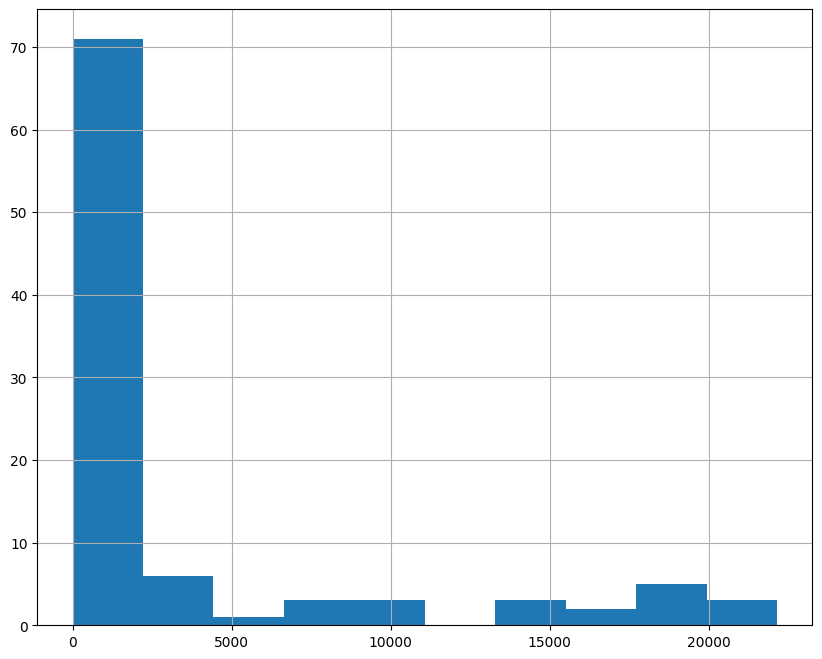

In [20]:
df['RegistrationYear'].value_counts().hist()

In [21]:
print(f'Количество некорректных данных — {100 - (df["RegistrationYear"][df["RegistrationYear"] <= 2020][df["RegistrationYear"] >= 1920].count() / len(df) * 100).round(3)}%')

Количество некорректных данных — 0.016999999999995907%


In [22]:
df = df.loc[df['RegistrationYear'].isin(df['RegistrationYear'][df["RegistrationYear"] <= 2020][df["RegistrationYear"] >= 1920])]

#### Gearbox

Это значение восстановить не получится.

In [23]:
print(f'Количество пропусков — {(df["Gearbox"].isna().sum() / len(df) * 100).round(3)}%')
df['Gearbox'].isna().sum()

Количество пропусков — 4.133%


13399

In [24]:
df = df.loc[~df['Gearbox'].isna()]

#### Model

Это значение восстановить не получится.

In [25]:
print(f'Количество пропусков — {(df["Model"].isna().sum() / len(df) * 100).round(3)}%')
df['Model'].isna().sum()

Количество пропусков — 3.152%


9796

In [26]:
df = df.loc[~df['Model'].isna()]

#### FuelType

In [27]:
print(f'Количество пропусков — {(df["FuelType"].isna().sum() / len(df) * 100).round(3)}%')
df['FuelType'].isna().sum()

Количество пропусков — 4.877%


14678

In [28]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

#### Repaired

Вероятнее всего пропущены значения "no".

In [29]:
df['Repaired'].value_counts()

no     225204
yes     29911
Name: Repaired, dtype: int64

In [30]:
print(f'Количество пропусков — {(df["Repaired"].isna().sum() / len(df) * 100).round(3)}%')
df['Repaired'].isna().sum()

Количество пропусков — 15.235%


45853

In [31]:
df["Repaired"].fillna("no", inplace=True)

#### Power

Много нулевых и околонулевых значений. Заполню их медианой.

In [32]:
print(f'Количество некорректных данных — {(df["Power"][df["Power"] <= 50].count() / len(df) * 100).round(3)}%')
df['Power'][df["Power"] == 0].count()

Количество некорректных данных — 0.0%


0

In [33]:
df['Power'].describe()

count    300968.000000
mean        121.041440
std          52.649472
min          51.000000
25%          79.000000
50%         113.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64

In [34]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 50), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [35]:
df = df.reset_index()
del df['index']

#### Посмотрим на корреляцию численных признаков.

In [36]:
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,101,golf,150000,petrol,volkswagen,no
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


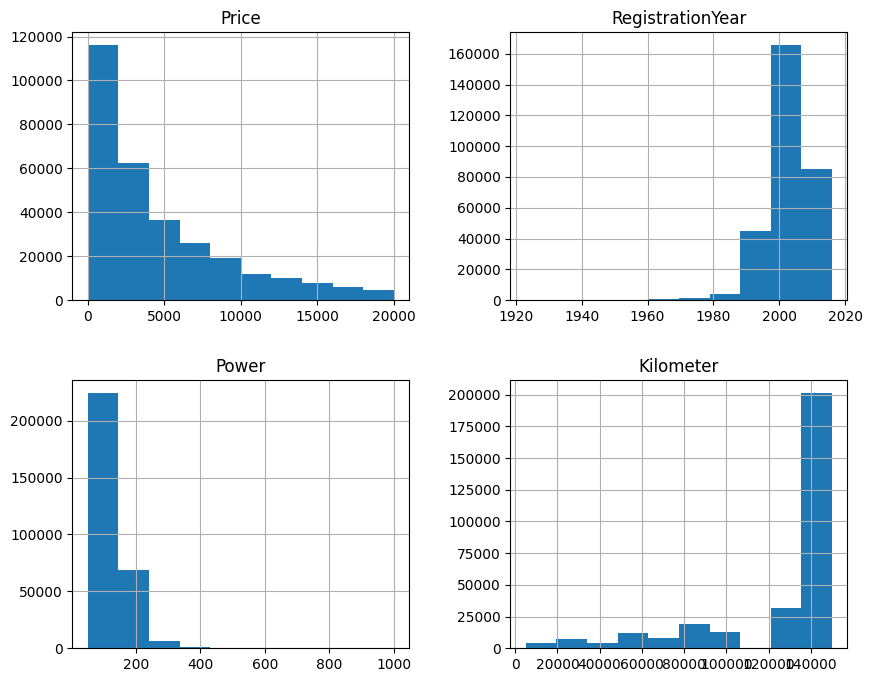

In [37]:
df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].hist()
plt.show()

In [38]:
df[['Price', 'RegistrationYear', 'Power', 'Kilometer']].corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.494320,0.497043,-0.386078
RegistrationYear,0.494320,1.000000,0.112589,-0.299452
Power,0.497043,0.112589,1.000000,0.094922
Kilometer,-0.386078,-0.299452,0.094922,1.000000


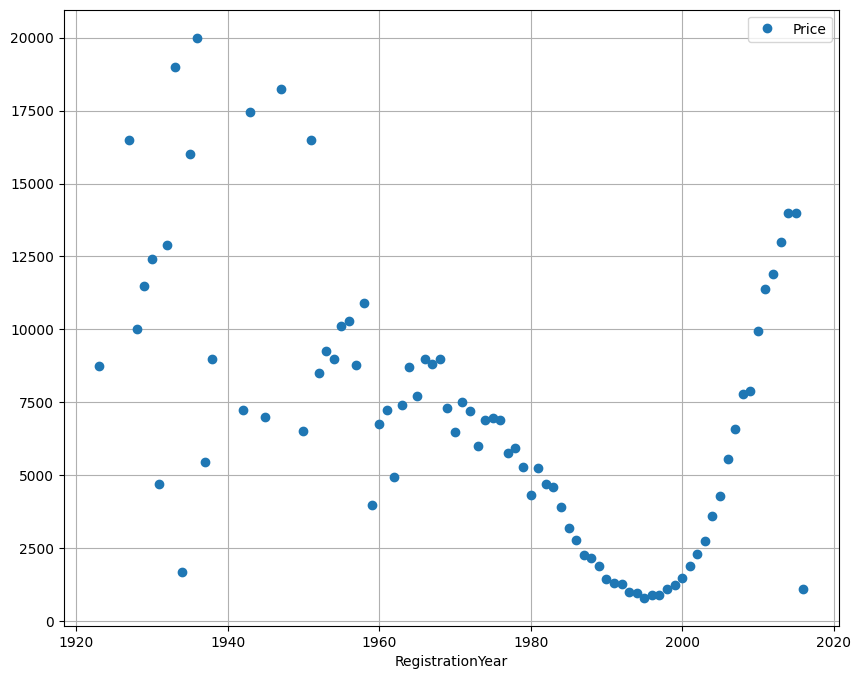

In [39]:
price_per_year = (
    df.pivot_table(index='RegistrationYear',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

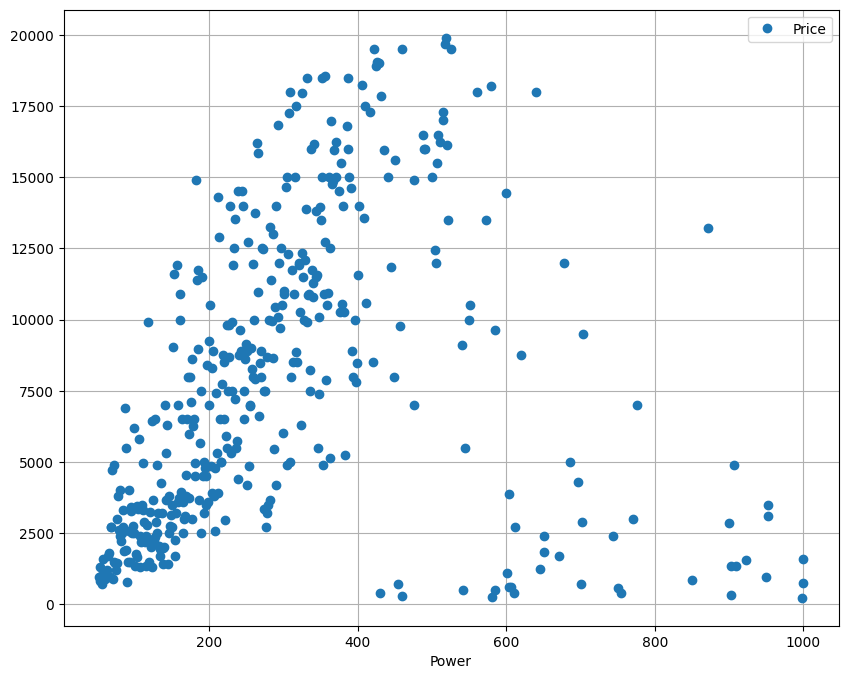

In [40]:
price_per_power = (
    df.pivot_table(index='Power',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

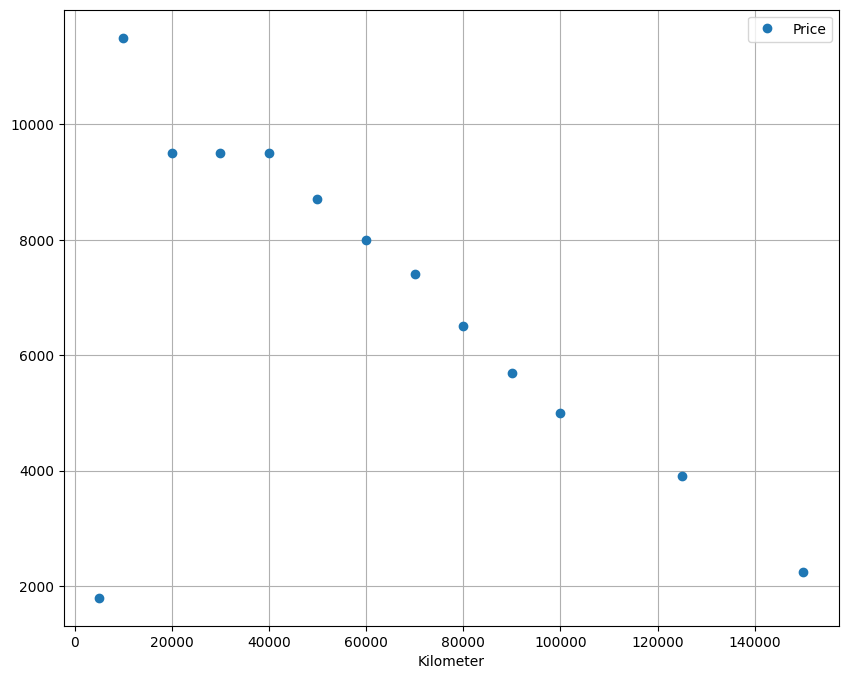

In [41]:
price_per_kilometer = (
    df.pivot_table(index='Kilometer',
                   values='Price',
                   aggfunc=('median')).sort_values(by='Price')
    .plot(style='o', grid=True)
)
plt.show()

**Вывод:**
* Автомобили, выпущенные в середине прошлого века, могут стоить как новые, их можно назвать антиквариатом. Старыми считаются автомобили выпущенные с 60 по 00 года, на них цена сильно ниже. Новые — выпщуенные после 00 годов, цена растет пропорционально новизне.
* Цена растет по мере повышения мощности автомобиля, но на высоких значениях видно падение стоимости.
* Чем выше пробег у автомобиля, тем меньше он будет стоить!

### Стратификация выборки.

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop('Price', axis=1), df['Price'], test_size=.4, random_state=666)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=.5, random_state=666)

### Кодирование категориальных признаков!

In [43]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(X_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [44]:
data1 = pd.DataFrame(enc.transform(X_train), columns=X_train.columns)

data1 = data1.reset_index()
del data1['index']
X_train = X_train.reset_index()
del X_train['index']

X_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data1[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [45]:
data2 = pd.DataFrame(enc.transform(X_val), columns=X_val.columns)

data2 = data2.reset_index()
del data2['index']
X_val = X_val.reset_index()
del X_val['index']

X_val[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data2[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [46]:
data3 = pd.DataFrame(enc.transform(X_test), columns=X_test.columns)

data3 = data3.reset_index()
del data3['index']
X_test = X_test.reset_index()
del X_test['index']

X_test[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']] = data3[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']].astype(int)

In [47]:
X_train.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2,1998,1,90,165,150000,6,35,0
1,4,1997,1,55,82,150000,6,24,1
2,1,2010,1,122,79,100000,6,21,0
3,7,2000,1,73,142,150000,6,37,0
4,4,1992,1,109,94,150000,6,20,0


In [48]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,300968.000000,300968.000000,300968.000000,300968.000000
mean,4761.712046,2002.814309,121.041440,128678.597060
std,4589.126054,6.432569,52.649472,36550.559539
min,1.000000,1923.000000,51.000000,5000.000000
25%,1299.000000,1999.000000,79.000000,125000.000000
50%,3000.000000,2003.000000,113.000000,150000.000000
75%,6900.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1000.000000,150000.000000


### Стандартизиция  признаков.

In [49]:
numeric = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2,-0.744168,1,-0.591396,0.818475,0.583369,6,1.125654,0
1,4,-0.899188,1,-1.258578,-0.364183,0.583369,6,0.278773,1
2,1,1.116064,1,0.018600,-0.406930,-0.785683,6,0.047806,0
3,7,-0.434130,1,-0.915456,0.490751,0.583369,6,1.279632,0
4,4,-1.674284,1,-0.229211,-0.193197,0.583369,6,-0.029184,0


**Вывод:**
* Избавился от пропусков и выбросов
* Удалил неинформативные столбцы
* Восстановил пропущенные значения
* Закодировал категориальные признаки методом Ordinal Encoding
* Разбил выборку на тренировочную, тестовую и валидационную
* Стандартизировал признаки

## Обучение моделей

### Random Forest Regressor

In [50]:
parameters={"max_depth" : [None] + [i for i in range(2, 11)],
           'n_estimators': [25,50,100,150]}


regr = RandomForestRegressor(random_state=666, max_features=4)

tuning_model_rfr = GridSearchCV(
    regr,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [51]:
tuning_model_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features=4, random_state=666),
             n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [52]:
tuning_model_rfr.best_params_

{'max_depth': None, 'n_estimators': 150}

In [56]:
%%time
model = RandomForestRegressor(random_state=666,
                              max_features=4,
                              max_depth=None,
                              n_estimators=150,
                              verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.7s


CPU times: user 1min 1s, sys: 1.36 s, total: 1min 2s
Wall time: 50.8 s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   50.4s finished


RandomForestRegressor(max_features=4, n_estimators=150, n_jobs=-1,
                      random_state=666, verbose=1)

In [54]:
%%time
y_pred_rfr = tuning_model_rfr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_rfr))}')

RMSE = 1544.7889652559627
CPU times: user 4.17 s, sys: 13.5 ms, total: 4.18 s
Wall time: 4.17 s


### Decision Tree Regressor

In [57]:
parameters={"max_depth" : [None] + [i for i in range(2, 11)],
           "min_samples_leaf":[None] + [i for i in range(2, 11)]}

regr = DecisionTreeRegressor(random_state=666)

tuning_model_dtr = GridSearchCV(
    regr,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)
tuning_model_dtr.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=666),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [None, 2, 3, 4, 5, 6, 7, 8, 9,
                                              10]},
             scoring='neg_mean_squared_error', verbose=1)

In [58]:
tuning_model_dtr.best_params_

{'max_depth': None, 'min_samples_leaf': 9}

In [59]:
%%time
model = DecisionTreeRegressor(random_state=666,
                              max_depth=None,
                              min_samples_leaf=9)
model.fit(X_train, y_train)

CPU times: user 577 ms, sys: 1.96 ms, total: 579 ms
Wall time: 579 ms


DecisionTreeRegressor(min_samples_leaf=9, random_state=666)

In [60]:
%%time
y_pred_dtr = tuning_model_dtr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_dtr))}')

RMSE = 1743.0740795587458
CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 30.3 ms


### Catboost

In [61]:
parameters =  {'depth': [6, 8],
               'l2_leaf_reg': [1, 3],
               'metric_period': [100]}

cbr = CatBoostRegressor(random_state=666, iterations=1000)
tuning_model_cbr = GridSearchCV(
    cbr,
    param_grid=parameters,
    cv=3,
    verbose=10,
    n_jobs=-1,
    scoring='r2',
)
tuning_model_cbr.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 4495.4527152	total: 85.3ms	remaining: 1m 25s
100:	learn: 1955.8431170	total: 3.16s	remaining: 28.1s
200:	learn: 1781.9113265	total: 6.06s	remaining: 24.1s
300:	learn: 1719.0100520	total: 10.8s	remaining: 25s
400:	learn: 1675.2156864	total: 13.7s	remaining: 20.4s
500:	learn: 1643.9184315	total: 16.6s	remaining: 16.6s
600:	learn: 1618.6595658	total: 19.6s	remaining: 13s
700:	learn: 1598.6384273	total: 24.3s	remaining: 10.4s
800:	learn: 1581.4380890	total: 27.2s	remaining: 6.76s
900:	learn: 1566.6694465	total: 30.2s	remaining: 3.31s
999:	learn: 1552.7200393	total: 33.1s	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa209eeab60>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'l2_leaf_reg': [1, 3],
                         'metric_period': [100]},
             scoring='r2', verbose=10)

In [62]:
tuning_model_cbr.best_params_

{'depth': 8, 'l2_leaf_reg': 1, 'metric_period': 100}

In [63]:
%%time
model = CatBoostRegressor(random_state=666,
                          depth=8,
                          iterations=1000,
                          l2_leaf_reg=1,
                          metric_period=100)
model.fit(X_train, y_train)

0:	learn: 4495.4527152	total: 35.9ms	remaining: 35.9s
100:	learn: 1955.8431170	total: 4.89s	remaining: 43.5s
200:	learn: 1781.9113265	total: 7.7s	remaining: 30.6s
300:	learn: 1719.0100520	total: 10.5s	remaining: 24.4s
400:	learn: 1675.2156864	total: 13.3s	remaining: 19.9s
500:	learn: 1643.9184315	total: 17.9s	remaining: 17.9s
600:	learn: 1618.6595658	total: 20.8s	remaining: 13.8s
700:	learn: 1598.6384273	total: 23.6s	remaining: 10.1s
800:	learn: 1581.4380890	total: 26.5s	remaining: 6.58s
900:	learn: 1566.6694465	total: 31.1s	remaining: 3.42s
999:	learn: 1552.7200393	total: 34s	remaining: 0us
CPU times: user 55.1 s, sys: 1.65 s, total: 56.8 s
Wall time: 34.2 s


In [64]:
%%time
y_pred_cbr = tuning_model_cbr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_cbr))}')

RMSE = 1603.2477445637883
CPU times: user 155 ms, sys: 2.71 ms, total: 158 ms
Wall time: 87.2 ms


### LGBMRegressor

In [67]:
params = {
    'max_depth': [None] + [i for i in range(2, 11)],
    'n_estimators': [25,50,100],
    'metric_period': [100]
}

lgbmr = LGBMRegressor(random_state=666, learning_rate=.1)

tuning_model_lgbmr = GridSearchCV(
    lgbmr,
    param_grid=params,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='r2'
)

tuning_model_lgbmr.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Unknown parameter: metric_period


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=666), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'metric_period': [100],
                         'n_estimators': [25, 50, 100]},
             scoring='r2', verbose=2)

In [68]:
tuning_model_lgbmr.best_params_

{'max_depth': None, 'metric_period': 100, 'n_estimators': 100}

In [69]:
%%time
lgbmr = LGBMRegressor(random_state=666, learning_rate=.1,
                     max_depth=None, n_estimators=100,
                      metric_period=100)
lgbmr.fit(X_train, y_train)

CPU times: user 4.61 s, sys: 26.8 ms, total: 4.64 s
Wall time: 3.6 s


LGBMRegressor(max_depth=None, metric_period=100, random_state=666)

In [70]:
%%time
y_pred_lgbmr = lgbmr.predict(X_val)
print(f'RMSE = {sqrt(mean_squared_error(y_val, y_pred_lgbmr))}')

RMSE = 1666.0172860638136
CPU times: user 612 ms, sys: 3.8 ms, total: 616 ms
Wall time: 564 ms


## Анализ моделей

**Лучшая модель по RMSE — Random Forest**

In [71]:
%%time
y_pred_rfr = tuning_model_rfr.predict(X_test)
print(f'RMSE = {sqrt(mean_squared_error(y_test, y_pred_rfr))}')

RMSE = 1561.438779647583
CPU times: user 5.48 s, sys: 9.02 ms, total: 5.49 s
Wall time: 7.66 s


На тестовой выборке RMSE такой же, как и на валидационной.

**В этом проекте я применил 4 модели машинного обучения:**

|	                     | fit time|predict time|	RMSE|
|----------------------|------|-----|------|
| RandomForestRegressor| 50.8 s|	4.17 s|	1544|
| DecisionTreeRegressor|	579 ms|	30.3 ms|	1743|
| CatBoostRegressor|	34.2 s|	87.2 ms|	1603|
| LGBMRegressor|	3.6 s|	564 ms|	1666|


**Лучшие показатели RMSE у случайного леса и кэтбуста, но кэтбуст незначительно выигрывает в скорости обучения.**